In [2]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

# LOG_PATH=Path('/scratch/da2734/twitter/sana/log/')
# DATA_PATH=Path('/scratch/da2734/twitter/sana/data')
# LABEL_PATH=Path('/scratch/da2734/twitter/sana/data/')
# OUTPUT_PATH=Path('/scratch/da2734/twitter/sana/output/')
LOG_PATH=Path('/scratch/da2734/twitter/mturk_mar6/log/')
DATA_PATH=Path('/scratch/da2734/twitter/mturk_mar6/data')
LABEL_PATH=Path('/scratch/da2734/twitter/mturk_mar6/data/')
OUTPUT_PATH=Path('/scratch/da2734/twitter/mturk_mar6/output_100')
FINETUNED_PATH = None

args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "labor_market_classification",
    "no_cuda": False,
#     "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 200,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'bert-base-uncased',
    "model_type": 'bert'
})

import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

# logger.info(args)

device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

label_cols = ["job_loss","is_unemployed","job_search","is_hired","job_offer"]

# databunch defined here https://github.com/kaushaltrivedi/fast-bert/blob/master/fast_bert/data_cls.py
databunch = BertDataBunch(
                        args['data_dir'], 
                        LABEL_PATH, 
                        args.model_name, 
                        train_file='train.csv', 
                        val_file='val.csv',
                        # test_data='test.csv',
                        text_col="text", #this is the name of the column in the train file that containts the tweet text
                        label_col=label_cols,
                        batch_size_per_gpu=args['train_batch_size'], 
                        max_seq_length=args['max_seq_length'], 
                        multi_gpu=args.multi_gpu, 
                        multi_label=True, 
                        model_type=args.model_type)

num_labels = len(databunch.labels)
print('num_labels', num_labels)

print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
# print ('Current cuda device ', torch.cuda.current_device)

# metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'roc_auc_save_to_plot', 'function': roc_auc_save_to_plot})
metrics.append({'name': 'fbeta', 'function': fbeta})
metrics.append({'name': 'accuracy', 'function': accuracy})
metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})


learner = BertLearner.from_pretrained_model(
                                            databunch, 
                                            pretrained_path='/scratch/da2734/twitter/mturk_mar6/output_100/model_out/', 
                                            metrics=metrics, 
                                            device=device, 
                                            logger=logger, 
                                            output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, 
                                            warmup_steps=args.warmup_steps,
                                            multi_gpu=args.multi_gpu, 
                                            is_fp16=args.fp16, 
                                            multi_label=True, 
                                            logging_steps=0)

print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')



/home/da2734/miniconda3/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


03/07/2020 15:33:16 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/da2734/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
03/07/2020 15:33:16 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data/cache/cached_bert_train_multi_label_512_train.csv
03/07/2020 15:33:16 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data/cache/cached_bert_dev_multi_label_512_val.csv
num_labels 5
__Python VERSION: 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
__pyTorch VERSION: 1.4.0
__CUDA VERSION
__CUDNN VERSION: 7603
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
03/07/2020 15:33:16 - INFO - transformers.configuration_utils -   loading configuration file /scratch/da2734/twi

In [3]:
from fast_bert.metrics import *
learner.validate()

03/07/2020 14:35:06 - INFO - root -   Running evaluation
03/07/2020 14:35:06 - INFO - root -     Num examples = 737
03/07/2020 14:35:06 - INFO - root -     Batch size = 32


{'loss': 0.24553525230536857,
 'accuracy_thresh': 0.9175034165382385,
 'roc_auc': 0.8943045254936353,
 'roc_auc_save_to_plot': 0.8943045254936353,
 'fbeta': 0.1971413791179657,
 'accuracy': 0.0,
 'accuracy_multilabel': 0.6390773405698779}

In [4]:
import pickle
output = pickle.load( open( "/scratch/da2734/twitter/mturk_mar6_roc_auc_save_to_plot.pkl", "rb" ) )

In [ ]:
from fast_bert.metrics import *
import inspect
roc_auc_code = inspect.getsource(roc_auc_save_to_plot)
print(roc_auc_code)

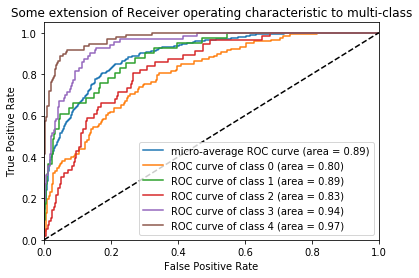

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fpr = output['fpr']
tpr = output['tpr']
roc_auc = output['roc_auc']
num_classes = 5

# Plot ROC curve
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [3]:
val = pd.read_csv('/scratch/da2734/twitter/mturk_mar6/data/val.csv')
val

,id,text,is_unemployed,lost_job_1mo,job_search,is_hired_1mo,job_offer
0,2949,Idiot attention-seeking Obama groupie. You are not worthy of a position of service to your country. YOUR FIRED! HAHA https://t.co/OxjzfboJ4J,0,0,0,0,0
1,2950,Last night I applied for a full-time good-pay position as a haha I wish but nOW I HAVE AN INTERVIEW ON WEDNESDAY???,1,0,1,0,0
2,2951,I was asked to take a supervisor position this morning and I said yaaaas lol,0,0,0,0,0
3,2952,this chick who took the position i applie to stopped showing up so my chances are high.,0,0,1,0,0
4,2953,@KoderKev HR did say the shorter they needed me for the temp the better it would be for the permanent position but it feels like I was fired,1,1,0,0,0
...,...,...,...,...,...,...,...
732,3681,Got hired today!!!,0,0,0,1,0
733,3682,Looking to get hired? Avoid these pitfalls https://t.co/HBNU1iKQZv tip @LinkedInPulse,0,0,0,0,0
734,3683,WOOOO one step closer to not being unemployed! #hired #wwddd https://t.co/ORocOEKpa0,1,0,0,1,0
735,3684,Anyone looking for a part time position in the St. Paul MN area? Message me for more details! #jobs #hiring #stpaul #sales #merchandising,0,0,0,0,1


In [4]:
val['text'][:3]

0    Idiot attention-seeking Obama groupie. You are not worthy of a position of service to your country. YOUR FIRED! HAHA https://t.co/OxjzfboJ4J
1    Last night I applied for a full-time good-pay position as a haha I wish but nOW I HAVE AN INTERVIEW ON WEDNESDAY???                         
2    I was asked to take a supervisor position this morning and I said yaaaas lol                                                                
Name: text, dtype: object

In [14]:
# texts = ['I just received a job offer']
texts = val['text'][:10].values.tolist()
# print(texts)
predictions = learner.predict_batch(texts)
i = 3
print(texts[i], predictions[i])

03/07/2020 15:38:23 - INFO - root -   Writing example 0 of 10
this chick who took the position i applie to stopped showing up so my chances are high. [('job_search', 0.07196473330259323), ('job_offer"', 0.07035087794065475), ('is_unemployed', 0.040677040815353394), ('is_hired_1mo', 0.03985217586159706), ('lost_job_1mo', 0.02201329730451107)]
